In [2]:
# Execute and Restart the kernel
!pip install scipy

In [3]:
# Imports
import torch
import torch.nn as nn

In [4]:
class DiffusionForwardProcess:  
    def __init__(self, num_time_steps = 1000, beta_start = 1e-4, beta_end = 0.02):
        self.betas = torch.linspace(beta_start, beta_end, num_time_steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - self.alpha_bars)
        
    def add_noise(self, original, noise, t):
        sqrt_alpha_bar_t = self.sqrt_alpha_bars.to(original.device)[t]
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bars.to(original.device)[t]
        sqrt_alpha_bar_t = sqrt_alpha_bar_t[:, None, None, None]
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar_t[:, None, None, None]
        return (sqrt_alpha_bar_t * original) + (sqrt_one_minus_alpha_bar_t * noise)

In [5]:
class DiffusionReverseProcess:
 
    def __init__(self, num_time_steps = 1000, beta_start = 1e-4, beta_end = 0.02):
        self.b = torch.linspace(beta_start, beta_end, num_time_steps)
        self.a = 1 - self.b
        self.a_bar = torch.cumprod(self.a, dim=0)
        
    def sample_prev_timestep(self, xt, noise_pred, t):  
        x0 = xt - (torch.sqrt(1 - self.a_bar.to(xt.device)[t]) * noise_pred)
        x0 = x0/torch.sqrt(self.a_bar.to(xt.device)[t])
        x0 = torch.clamp(x0, -1., 1.) 
        mean = (xt - ((1 - self.a.to(xt.device)[t]) * noise_pred)/(torch.sqrt(1 - self.a_bar.to(xt.device)[t])))
        mean = mean/(torch.sqrt(self.a.to(xt.device)[t]))
        if t == 0:
            return mean, x0
        else:
            variance =  (1 - self.a_bar.to(xt.device)[t-1])/(1 - self.a_bar.to(xt.device)[t])
            variance = variance * self.b.to(xt.device)[t]
            sigma = variance**0.5
            z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0

In [6]:
def get_time_embedding(
    time_steps: torch.Tensor,
    t_emb_dim: int
) -> torch.Tensor:
    
    """ 
    Transform a scalar time-step into a vector representation of size t_emb_dim.
    
    :param time_steps: 1D tensor of size -> (Batch,)
    :param t_emb_dim: Embedding Dimension -> for ex: 128 (scalar value)
    
    :return tensor of size -> (B, t_emb_dim)
    """
    
    assert t_emb_dim%2 == 0, "time embedding must be divisible by 2."
    
    factor = 2 * torch.arange(start = 0, 
                              end = t_emb_dim//2, 
                              dtype=torch.float32, 
                              device=time_steps.device
                             ) / (t_emb_dim)
    
    factor = 10000**factor

    t_emb = time_steps[:,None] # B -> (B, 1) 
    t_emb = t_emb/factor # (B, 1) -> (B, t_emb_dim//2)
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=1) # (B , t_emb_dim)
    
    return t_emb

In [7]:
class NormActConv(nn.Module):
    def __init__(self, in_channels:int, out_channels:int, num_groups:int = 8, kernel_size: int = 3, 
norm:bool = True,act:bool = True):
        super(NormActConv, self).__init__()
        self.g_norm = nn.GroupNorm(num_groups,in_channels) if norm is True else nn.Identity()
        self.act = nn.SiLU() if act is True else nn.Identity()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size, padding=(kernel_size - 1)//2) 
    def forward(self, x):
        x = self.g_norm(x)
        x = self.act(x)
        x = self.conv(x)
        return x
class TimeEmbedding(nn.Module):
    def __init__(self, n_out:int,t_emb_dim:int = 128):
        super(TimeEmbedding, self).__init__()
        self.te_block = nn.Sequential(nn.SiLU(), nn.Linear(t_emb_dim, n_out))
    def forward(self, x):
        return self.te_block(x)
    
class SelfAttentionBlock(nn.Module):
    def __init__(self,num_channels:int,num_groups:int = 8, num_heads:int = 4,norm:bool = True):
        super(SelfAttentionBlock, self).__init__()
        self.g_norm = nn.GroupNorm(num_groups,num_channels) if norm is True else nn.Identity()
        self.attn = nn.MultiheadAttention(num_channels,num_heads,batch_first=True)
        
    def forward(self, x):
        batch_size, channels, h, w = x.shape
        x = x.reshape(batch_size, channels, h*w)
        x = self.g_norm(x)
        x = x.transpose(1, 2)
        x, _ = self.attn(x, x, x)
        x = x.transpose(1, 2).reshape(batch_size, channels, h, w)
        return x
    
class Downsample(nn.Module):
    def __init__(self, in_channels:int, out_channels:int, k:int = 2,use_conv:bool = True,
 use_mpool:bool = True ):
        super(Downsample, self).__init__()
        self.use_conv = use_conv
        self.use_mpool = use_mpool
        self.cv = nn.Sequential(nn.Conv2d(in_channels, in_channels, kernel_size=1), 
            nn.Conv2d(in_channels, out_channels//2 if use_mpool else out_channels, 
                kernel_size=4,stride=k, padding=1)
        ) if use_conv else nn.Identity()
        
        self.mpool = nn.Sequential(nn.MaxPool2d(k, k), 
            nn.Conv2d(in_channels, out_channels//2 if use_conv else out_channels, 
                kernel_size=1, stride=1, padding=0)) if use_mpool else nn.Identity()

    def forward(self, x):
        if not self.use_conv:return self.mpool(x)
        if not self.use_mpool:return self.cv(x)
        return torch.cat([self.cv(x), self.mpool(x)], dim=1)

class Upsample(nn.Module):
    """
    Perform Upsampling by the factor of k across Height and Width
    """
    def __init__(self, in_channels:int, out_channels:int, k:int = 2,use_conv:bool = True, 
                 use_upsample:bool = True):
        super(Upsample, self).__init__()
        
        self.use_conv = use_conv
        self.use_upsample = use_upsample
        
        # Upsampling using conv
        self.cv = nn.Sequential(nn.ConvTranspose2d(in_channels,out_channels//2 if use_upsample else out_channels, 
                kernel_size=4, stride=k, padding=1),
            nn.Conv2d(out_channels//2 if use_upsample else out_channels, 
                out_channels//2 if use_upsample else out_channels, kernel_size = 1, stride=1, padding=0
            )
        ) if use_conv else nn.Identity()
        
        # Upsamling using nn.Upsample
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=k, mode = 'bilinear', align_corners=False),
            nn.Conv2d(in_channels,out_channels//2 if use_conv else out_channels, kernel_size=1, stride=1, padding=0)
        ) if use_upsample else nn.Identity()
        
    def forward(self, x):
        if not self.use_conv:
            return self.up(x)
        if not self.use_upsample:
            return self.cv(x)
        return torch.cat([self.cv(x), self.up(x)], dim=1)

In [8]:
class DownC(nn.Module):
    """
    Perform Down-convolution on the input using following approach.
    1. Conv + TimeEmbedding
    2. Conv
    3. Skip-connection from input x.
    4. Self-Attention
    5. Skip-Connection from 3.
    6. Downsampling
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 t_emb_dim:int = 128, # Time Embedding Dimension
                 num_layers:int=2,
                 down_sample:bool = True # True for Downsampling
                ):
        super(DownC, self).__init__()
        
        self.num_layers = num_layers
        
        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels, 
                        out_channels
                       ) for i in range(num_layers)
        ])
        
        self.conv2 = nn.ModuleList([
            NormActConv(out_channels, 
                        out_channels
                       ) for _ in range(num_layers)
        ])
        
        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers)
        ])
        
        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])
        
        self.down_block =Downsample(out_channels, out_channels) if down_sample else nn.Identity()
        
        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels, 
                out_channels, 
                kernel_size=1
            ) for i in range(num_layers)
        ])
        
    def forward(self, x, t_emb):
        
        out = x
        
        for i in range(self.num_layers):
            resnet_input = out
            
            # Resnet Block
            out = self.conv1[i](out)
            out = out + self.te_block[i](t_emb)[:, :, None, None]
            out = self.conv2[i](out)
            out = out + self.res_block[i](resnet_input)

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn

        # Downsampling
        out = self.down_block(out)
        
        return out

In [9]:
class MidC(nn.Module):
    """
    Refine the features obtained from the DownC block.
    It refines the features using following operations:
    
    1. Resnet Block with Time Embedding
    2. A Series of Self-Attention + Resnet Block with Time-Embedding 
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int,
                 t_emb_dim:int = 128,
                 num_layers:int = 2
                ):
        super(MidC, self).__init__()
        
        self.num_layers = num_layers
        
        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels, 
                        out_channels
                       ) for i in range(num_layers + 1)
        ])
        
        self.conv2 = nn.ModuleList([
            NormActConv(out_channels, 
                        out_channels
                       ) for _ in range(num_layers + 1)
        ])
        
        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers + 1)
        ])
        
        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])
        
        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels, 
                out_channels, 
                kernel_size=1
            ) for i in range(num_layers + 1)
        ])
        
    def forward(self, x, t_emb):
        out = x
        
        # First-Resnet Block
        resnet_input = out
        out = self.conv1[0](out)
        out = out + self.te_block[0](t_emb)[:, :, None, None]
        out = self.conv2[0](out)
        out = out + self.res_block[0](resnet_input)
        
        # Sequence of Self-Attention + Resnet Blocks
        for i in range(self.num_layers):
            
            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn
            
            # Resnet Block
            resnet_input = out
            out = self.conv1[i+1](out)
            out = out + self.te_block[i+1](t_emb)[:, :, None, None]
            out = self.conv2[i+1](out)
            out = out + self.res_block[i+1](resnet_input)
            
        return out

In [10]:
class UpC(nn.Module):
    """
    Perform Up-convolution on the input using following approach.
    1. Upsampling
    2. Conv + TimeEmbedding
    3. Conv
    4. Skip-connection from 1.
    5. Self-Attention
    6. Skip-Connection from 3.
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 t_emb_dim:int = 128, # Time Embedding Dimension
                 num_layers:int = 2,
                 up_sample:bool = True # True for Upsampling
                ):
        super(UpC, self).__init__()
        
        self.num_layers = num_layers
        
        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels, 
                        out_channels
                       ) for i in range(num_layers)
        ])
        
        self.conv2 = nn.ModuleList([
            NormActConv(out_channels, 
                        out_channels
                       ) for _ in range(num_layers)
        ])
        
        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers)
        ])
        
        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])
        
        self.up_block =Upsample(in_channels, in_channels//2) if up_sample else nn.Identity()
        
        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels, 
                out_channels, 
                kernel_size=1
            ) for i in range(num_layers)
        ])
        
    def forward(self, x, down_out, t_emb):
        
        # Upsampling
        x = self.up_block(x)
        x = torch.cat([x, down_out], dim=1)
        
        out = x
        for i in range(self.num_layers):
            resnet_input = out
            
            # Resnet Block
            out = self.conv1[i](out)
            out = out + self.te_block[i](t_emb)[:, :, None, None]
            out = self.conv2[i](out)
            out = out + self.res_block[i](resnet_input)

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn
        
        return out

In [11]:
class Unet(nn.Module):
    """
    U-net architecture which is used to predict noise
    in the paper "Denoising Diffusion Probabilistic Model".
    
    U-net consists of Series of DownC blocks followed by MidC
    followed by UpC.
    """
    
    def __init__(self,
                 im_channels: int = 1, # RGB 
                 down_ch: list = [32, 64, 128, 256],
                 mid_ch: list = [256, 256, 128],
                 up_ch: list[int] = [256, 128, 64, 16],
                 down_sample: list[bool] = [True, True, False],
                 t_emb_dim: int = 128,
                 num_downc_layers:int = 2, 
                 num_midc_layers:int = 2, 
                 num_upc_layers:int = 2
                ):
        super(Unet, self).__init__()
        
        self.im_channels = im_channels
        self.down_ch = down_ch
        self.mid_ch = mid_ch
        self.up_ch = up_ch
        self.t_emb_dim = t_emb_dim
        self.down_sample = down_sample
        self.num_downc_layers = num_downc_layers
        self.num_midc_layers = num_midc_layers
        self.num_upc_layers = num_upc_layers
        
        self.up_sample = list(reversed(self.down_sample)) # [False, True, True]
        
        # Initial Convolution
        self.cv1 = nn.Conv2d(self.im_channels, self.down_ch[0], kernel_size=3, padding=1)
        
        # Initial Time Embedding Projection
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim), 
            nn.SiLU(), 
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )
        
        # DownC Blocks
        self.downs = nn.ModuleList([
            DownC(
                self.down_ch[i], 
                self.down_ch[i+1], 
                self.t_emb_dim, 
                self.num_downc_layers, 
                self.down_sample[i]
            ) for i in range(len(self.down_ch) - 1)
        ])
        
        # MidC Block
        self.mids = nn.ModuleList([
            MidC(
                self.mid_ch[i], 
                self.mid_ch[i+1], 
                self.t_emb_dim, 
                self.num_midc_layers
            ) for i in range(len(self.mid_ch) - 1)
        ])
        
        # UpC Block
        self.ups = nn.ModuleList([
            UpC(
                self.up_ch[i], 
                self.up_ch[i+1], 
                self.t_emb_dim, 
                self.num_upc_layers, 
                self.up_sample[i]
            ) for i in range(len(self.up_ch) - 1)
        ])
        
        # Final Convolution
        self.cv2 = nn.Sequential(
            nn.GroupNorm(8, self.up_ch[-1]), 
            nn.Conv2d(self.up_ch[-1], self.im_channels, kernel_size=3, padding=1)
        )
        
    def forward(self, x, t):
        
        out = self.cv1(x)
        
        # Time Projection
        t_emb = get_time_embedding(t, self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        # DownC outputs
        down_outs = []
        
        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb)
        
        # MidC outputs
        for mid in self.mids:
            out = mid(out, t_emb)
        
        # UpC Blocks
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
            
        # Final Conv
        out = self.cv2(out)
        
        return out

In [12]:
model = Unet()

In [13]:
import pandas as pd
import numpy as np
import torchvision
from torch.utils.data.dataset import Dataset

class CustomMnistDataset(Dataset):
    """
    Reads the MNIST data from csv file given file path.
    """
    def __init__(self, csv_path, num_datapoints = None):
        super(CustomMnistDataset, self).__init__()
        
        self.df = pd.read_csv(csv_path)
        
        # Will be useful later while evaluating
        if num_datapoints is not None:
            self.df = self.df.iloc[0:num_datapoints]
      
    def __len__(self):
        return len(self.df)
    
    def  __getitem__(self, index):
        # Read
        img = self.df.iloc[index].filter(regex='pixel').values
        img =  np.reshape(img, (28, 28)).astype(np.uint8)
        
        # Convert to Tensor
        img_tensor = torchvision.transforms.ToTensor()(img) # [0, 1]
        img_tensor = 2*img_tensor - 1 # [-1, 1]
        
        return img_tensor

In [14]:
class CONFIG:
    model_path = 'ddpm_unet.pth'
    train_csv_path = '/kaggle/input/digit-recognizer/train.csv'
    test_csv_path = '/kaggle/input/digit-recognizer/test.csv'
    generated_csv_path = 'mnist_generated_data.csv'
    num_epochs = 20
    lr = 1e-4
    num_timesteps = 1000
    batch_size = 128
    img_size = 28
    in_channels = 1
    num_img_to_generate = 64

In [15]:
from torch.utils.data import DataLoader
from tqdm import tqdm

def train(cfg):
    
    # Dataset and Dataloader
    mnist_ds = CustomMnistDataset(cfg.train_csv_path)
    mnist_dl = DataLoader(mnist_ds, cfg.batch_size, shuffle=True)
    
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}\n')
    
    # Initiate Model
    model = Unet().to(device)
    
    # Initialize Optimizer and Loss Function
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    criterion = torch.nn.MSELoss()
    
    # Diffusion Forward Process to add noise
    dfp = DiffusionForwardProcess()
    
    # Best Loss
    best_eval_loss = float('inf')
    
    # Train
    for epoch in range(cfg.num_epochs):
        
        # For Loss Tracking
        losses = []
        
        # Set model to train mode
        model.train()
        
        # Loop over dataloader
        for imgs in tqdm(mnist_dl):
            
            imgs = imgs.to(device)
            
            # Generate noise and timestamps
            noise = torch.randn_like(imgs).to(device)
            t = torch.randint(0, cfg.num_timesteps, (imgs.shape[0],)).to(device)
            
            # Add noise to the images using Forward Process
            noisy_imgs = dfp.add_noise(imgs, noise, t)
            
            # Avoid Gradient Accumulation
            optimizer.zero_grad()
            
            # Predict noise using U-net Model
            noise_pred = model(noisy_imgs, t)
            
            # Calculate Loss
            loss = criterion(noise_pred, noise)
            losses.append(loss.item())
            
            # Backprop + Update model params
            loss.backward()
            optimizer.step()
        
        # Mean Loss
        mean_epoch_loss = np.mean(losses)
        
        # Display
        print('Epoch:{} | Loss : {:.4f}'.format(
            epoch + 1,
            mean_epoch_loss,
        ))
        
        # Save based on train-loss
        if mean_epoch_loss < best_eval_loss:
            best_eval_loss = mean_epoch_loss
            torch.save(model, cfg.model_path)
            
    print(f'Done training.....')

In [16]:
# Config
cfg = CONFIG()

# TRAIN
train(cfg)

Device: cuda



100%|██████████| 329/329 [02:26<00:00,  2.24it/s]


Epoch:1 | Loss : 0.1957


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:2 | Loss : 0.0576


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:3 | Loss : 0.0438


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:4 | Loss : 0.0378


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:5 | Loss : 0.0339


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:6 | Loss : 0.0318


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:7 | Loss : 0.0304


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:8 | Loss : 0.0292


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:9 | Loss : 0.0285


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:10 | Loss : 0.0275


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:11 | Loss : 0.0271


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:12 | Loss : 0.0266


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:13 | Loss : 0.0259


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:14 | Loss : 0.0256


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:15 | Loss : 0.0257


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:16 | Loss : 0.0256


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:17 | Loss : 0.0253


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:18 | Loss : 0.0247


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Epoch:19 | Loss : 0.0249


100%|██████████| 329/329 [02:25<00:00,  2.26it/s]

Epoch:20 | Loss : 0.0246
Done training.....


In [17]:
def generate(cfg):
    """
    Given Pretrained DDPM U-net model, Generate Real-life
    Images from noise by going backward step by step. i.e.,
    Mapping of Random Noise to Real-life images.
    """
    
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #print(f'Device: {device}\n')
    
    # Initialize Diffusion Reverse Process
    drp = DiffusionReverseProcess()
    
    # Set model to eval mode
    model = torch.load(cfg.model_path).to(device)
    model.eval()
    
    # Generate Noise sample from N(0, 1)
    xt = torch.randn(1, cfg.in_channels, cfg.img_size, cfg.img_size).to(device)
    
    # Denoise step by step by going backward.
    with torch.no_grad():
        for t in reversed(range(cfg.num_timesteps)):
            noise_pred = model(xt, torch.as_tensor(t).unsqueeze(0).to(device))
            xt, x0 = drp.sample_prev_timestep(xt, noise_pred, torch.as_tensor(t).to(device))

    # Convert the image to proper scale
    xt = torch.clamp(xt, -1., 1.).detach().cpu()
    xt = (xt + 1) / 2
    
    return xt

100%|██████████| 64/64 [19:47<00:00, 18.56s/it]


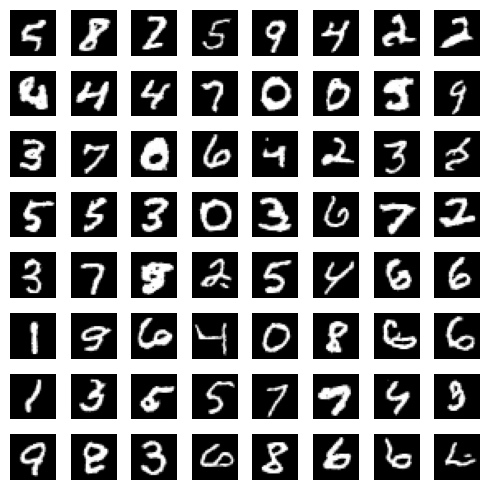

In [18]:
# Load model and config
cfg = CONFIG()

# Generate
generated_imgs = []
for i in tqdm(range(cfg.num_img_to_generate)):
    xt = generate(cfg)
    xt = 255 * xt[0][0].numpy()
    generated_imgs.append(xt.astype(np.uint8).flatten())

# Save Generated Data CSV
generated_df = pd.DataFrame(generated_imgs, columns=[f'pixel{i}' for i in range(784)])
generated_df.to_csv(cfg.generated_csv_path, index=False)

# Visualize
from matplotlib import pyplot as plt
fig, axes = plt.subplots(8, 8, figsize=(5, 5))

# Plot each image in the corresponding subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(np.reshape(generated_imgs[i], (28, 28)), cmap='gray')  # You might need to adjust the colormap based on your images
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()  # Adjust spacing between subplots
plt.show()